# Export tensorflow models
This Notebook is intended to export tensorflow models to constant graph protobuf files.

In [1]:
import os,sys
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
import tensorflow as tf
import numpy as np
from keras import backend as K
import tables
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
# Directories for models
custom_weights_dir_q = os.path.expanduser("../weights-quantized-224x224-fixval-best-final/")
custom_weights_dir = os.path.expanduser("../weights-floatingpoint-224x224-fixval-best/")
saved_model_dir = os.path.expanduser("../machinelearningnotebooks/models/")

## Prepare Data
Load the files we are going to use for training and testing. The public Top dataset consists of image formatted data, but our data has been preprocessed into a raw form. You will need to edit the paths as necessary.

In [7]:
from utils import normalize_and_rgb, image_with_label, count_events, construct_model

In [4]:
import glob
# for 224x224:
datadir = "../../converted/rotation_224_v1/"
data_size = 224 #image width/height
n_test_file = 1
test_files = glob.glob(os.path.join(datadir, 'test_file_*'))
n_test_events = count_events(test_files)
print("n_test_events =", n_test_events)

n_test_events = 404000


/home/jduarte/miniconda/envs/myamlenv/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


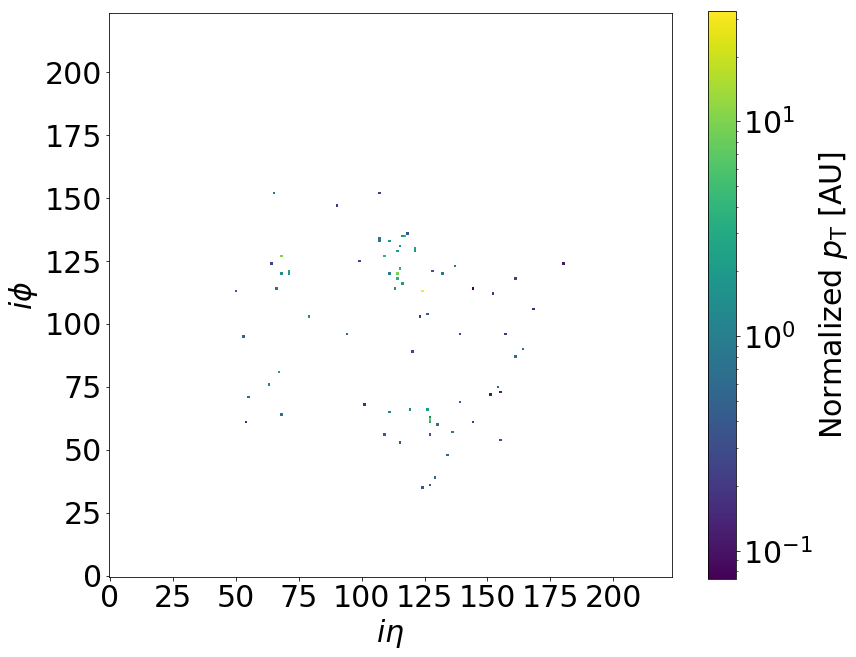

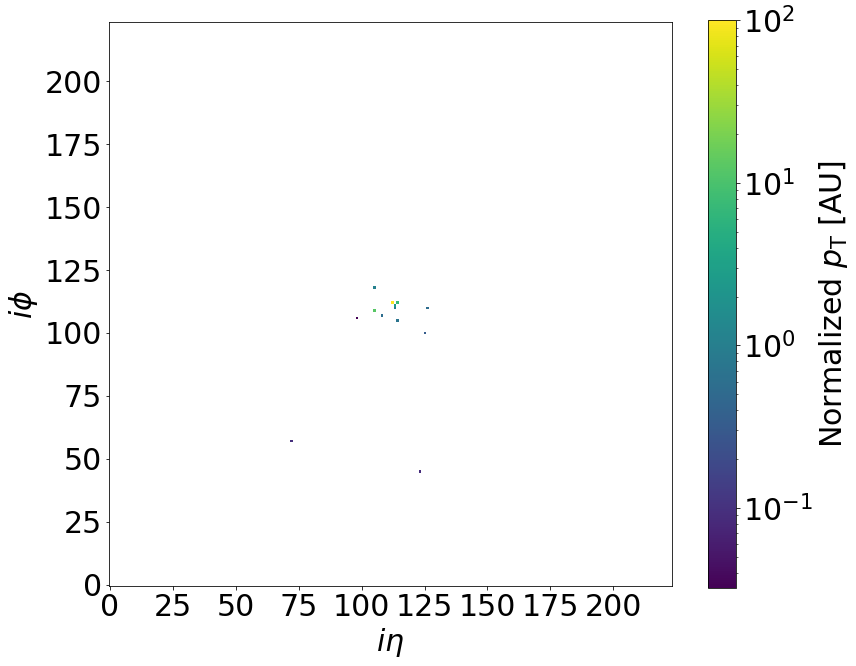

In [7]:
def test_heatmap(train_files, size=224):
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import numpy as np
    
    a, b = image_with_label(train_files[0],0,100)
    a = a[0:100:60] # pick one top image [0] and one QCD image [59]
    b = b[0:100:60] 
    new_a = np.swapaxes(a[:,:,:,0],0,2)
    new_a = np.swapaxes(new_a,0,1)
    # pick top image
    c = np.dot(new_a,b[:,0])/a.shape[0]
    # pick QCD image
    d = np.dot(new_a,b[:,1])/a.shape[0]

    width = 12
    height = 12
    fontsize = 30

    plt.style.use('sonic.mplstyle')
    plt.figure(figsize=(width,height))
    ax = plt.subplot() 
    for label in (ax.get_xticklabels() + ax.get_yticklabels()): label.set_fontsize(fontsize)
    plt.imshow(c, norm=mpl.colors.LogNorm(), origin='lower', interpolation='nearest',label='top')
    cbar = plt.colorbar(shrink=0.675)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.set_label(r'Normalized $p_{\mathrm{T}}$ [AU]', fontsize=fontsize)
    plt.xlabel(r'$i\eta$', fontsize=fontsize)
    plt.ylabel(r'$i\phi$', fontsize=fontsize)
    plt.tight_layout()
    plt.savefig('top_%sx%s.pdf'%(size,size))

    plt.style.use('sonic.mplstyle')
    plt.figure(figsize=(width,height))
    ax = plt.subplot() 
    for label in (ax.get_xticklabels() + ax.get_yticklabels()): label.set_fontsize(fontsize)
    plt.imshow(d, norm=mpl.colors.LogNorm(), origin='lower', interpolation='nearest',label='QCD')
    cbar = plt.colorbar(shrink=0.675)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.set_label(r'Normalized $p_{\mathrm{T}}$ [AU]', fontsize=fontsize)
    plt.xlabel(r'$i\eta$', fontsize=fontsize)
    plt.ylabel(r'$i\phi$', fontsize=fontsize)
    plt.tight_layout()
    plt.savefig('QCD_%sx%s.pdf'%(size,size))
%matplotlib inline
test_heatmap(test_files,224)

## Load The Model

In [9]:
tf.reset_default_graph()
sess = tf.Session(graph=tf.get_default_graph())

with sess.as_default():
    print("Loading quantized model")
    in_images, image_tensors, features, preds, quantized_featurizer, classifier = construct_model(quantized=True, 
                                                                                                  saved_model_dir=saved_model_dir, 
                                                                                                  starting_weights_directory=custom_weights_dir_q, 
                                                                                                  is_training=False, 
                                                                                                  size=data_size)
    print(preds.name)
    pred_node_names = [preds.name[:-2]]

    K.set_learning_phase(0)
    saver = tf.train.Saver()
    tfoutpath=custom_weights_dir_q+'/tf.checkpoint'

    from tensorflow.python.framework import graph_util
    from tensorflow.python.framework import graph_io
    
    constant_graph = graph_util.convert_variables_to_constants(sess, sess.graph.as_graph_def(), pred_node_names)

    f = 'constantgraph.pb.ascii'
    tf.train.write_graph(constant_graph, custom_weights_dir_q, f, as_text=True)
    print('saved the graph definition in ascii format at: ', os.path.join(custom_weights_dir_q, f))

    f = 'constantgraph.pb'
    tf.train.write_graph(constant_graph, custom_weights_dir_q, f, as_text=False)
    print('saved the graph definition in pb format at: ', os.path.join(custom_weights_dir_q, f))

    saver.save(sess, tfoutpath)
    
    from utils import chunks, test_model

Loading quantized model
INFO:tensorflow:Restoring parameters from ../weights-quantized-224x224-fixval-best-final/tf.checkpoint
loading classifier weights from ../weights-quantized-224x224-fixval-best-final//class_weights_best.h5
classifier/model_1/classifier_output/Softmax:0
INFO:tensorflow:Froze 269 variables.
INFO:tensorflow:Converted 269 variables to const ops.
saved the graph definition in ascii format at:  ../weights-quantized-224x224-fixval-best-final/constantgraph.pb.ascii
saved the graph definition in pb format at:  ../weights-quantized-224x224-fixval-best-final/constantgraph.pb


In [10]:
tf.reset_default_graph()
sess = tf.Session(graph=tf.get_default_graph())

with sess.as_default():
    print("Loading a trained model")
    in_images, image_tensors, features, preds, featurizer, classifier = construct_model(quantized=False, 
                                                                                        saved_model_dir=saved_model_dir, 
                                                                                        starting_weights_directory=custom_weights_dir, 
                                                                                        is_training=False, 
                                                                                        size=data_size)
    print(preds.name)
    pred_node_names = [preds.name[:-2]]

    K.set_learning_phase(0)
    saver = tf.train.Saver()
    tfoutpath=custom_weights_dir+'/tf.checkpoint'

    from tensorflow.python.framework import graph_util
    from tensorflow.python.framework import graph_io
    
    constant_graph = graph_util.convert_variables_to_constants(sess, sess.graph.as_graph_def(), pred_node_names)

    f = 'constantgraph.pb.ascii'
    tf.train.write_graph(constant_graph, custom_weights_dir, f, as_text=True)
    print('saved the graph definition in ascii format at: ', os.path.join(custom_weights_dir, f))

    f = 'constantgraph.pb'
    tf.train.write_graph(constant_graph, custom_weights_dir, f, as_text=False)
    print('saved the graph definition in pb format at: ', os.path.join(custom_weights_dir, f))

    saver.save(sess, tfoutpath)

Loading a trained model
INFO:tensorflow:Restoring parameters from ../weights-floatingpoint-224x224-fixval-best/tf.checkpoint
loading classifier weights from ../weights-floatingpoint-224x224-fixval-best//class_weights_best.h5
classifier/model_1/classifier_output/Softmax:0
INFO:tensorflow:Froze 269 variables.
INFO:tensorflow:Converted 269 variables to const ops.
saved the graph definition in ascii format at:  ../weights-floatingpoint-224x224-fixval-best/constantgraph.pb.ascii
saved the graph definition in pb format at:  ../weights-floatingpoint-224x224-fixval-best/constantgraph.pb
